<a href="https://colab.research.google.com/github/cr7258/hands-on-lab/blob/main/ai/fine-tuning/01-bitfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step0 导入相关模块

In [ ]:
!pip install datasets transformers

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

In [3]:
import datasets
datasets.__version__

'3.5.0'

In [4]:
import transformers
transformers.__version__

'4.51.3'

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Step1 查看模型训练前的推理效果

In [6]:
# 加载 Langboat 中文 Bloom 模型和分词器
model_name = "Langboat/bloom-1b4-zh"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# 构造输入
prompt = "Human: 三原色是什么？\n\nAssistant:"
inputs = tokenizer(prompt, return_tensors="pt")

# 可选：使用 GPU
model = model.to("cuda")
inputs = {k: v.to("cuda") for k, v in inputs.items()}

# 推理生成
output = model.generate(
    **inputs,
    max_new_tokens=100,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    pad_token_id=tokenizer.eos_token_id
)

# 解码输出
tokenizer.decode(output[0], skip_special_tokens=True)


tokenizer_config.json:   0%|          | 0.00/268 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.66M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.59G [00:00<?, ?B/s]

'Human: 三原色是什么？\n\nAssistant:\n- 绿色。\n- 绿色。\nAssistant:\n- 蓝色。\n- 蓝色。\nAssistant:\n- 红色。\n- 红色。\n- 红色。\nAssistant:\n- 蓝色。\n- 蓝色。\nAssistant:\n- 绿色。\n- 绿色。\nAssistant:\n- 蓝色。\n- 蓝色。\nAssistant:\n- 红色。\n- 红色。\nAssistant:\n- 蓝色。\n- 蓝色。\nAssistant:'

In [7]:
model.device

device(type='cuda', index=0)

# Step2 加载数据集

In [9]:
# 如果使用 Google colab 需要手动上传数据集
# https://github.com/cr7258/hands-on-lab/tree/main/ai/fine-tuning/01-alpaca_data_zh
ds = load_dataset("json", data_dir="./01-alpaca_data_zh/")
ds = ds['train']
ds

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 48818
})

In [10]:
# 展示 3 条样本
ds[:3]

{'instruction': ['保持健康的三个提示。', '三原色是什么？', '描述原子的结构。'],
 'input': ['', '', ''],
 'output': ['以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。',
  '三原色通常指的是红色、绿色和蓝色（RGB）。它们是通过加色混合原理创建色彩的三种基础颜色。在以发光为基础的显示设备中（如电视、计算机显示器、智能手机和平板电脑显示屏）, 三原色可混合产生大量色彩。其中红色和绿色可以混合生成黄色，红色和蓝色可以混合生成品红色，蓝色和绿色可以混合生成青色。当红色、绿色和蓝色按相等比例混合时，可以产生白色或灰色。\n\n此外，在印刷和绘画中，三原色指的是以颜料为基础的红、黄和蓝颜色（RYB）。这三种颜色用以通过减色混合原理来创建色彩。不过，三原色的具体定义并不唯一，不同的颜色系统可能会采用不同的三原色。',
  '原子是物质的基本单位，它由三种基本粒子组成：质子、中子和电子。质子和中子形成原子核，位于原子中心，核外的电子围绕着原子核运动。\n\n原子结构具有层次性。原子核中，质子带正电，中子不带电（中性）。原子核非常小且致密，占据了原子总质量的绝大部分。电子带负电，通常围绕核运动，形成若干层次，称为壳层或电子层。电子数量与质子数量相等，使原子呈电中性。\n\n电子在每个壳层中都呈规律分布，并且不同壳层所能容纳的电子数也不同。在最里面的壳层一般只能容纳2个电子，其次一层最多可容纳8个电子，再往外的壳层可容纳的电子数逐层递增。\n\n原子核主要受到两种相互作用力的影响：强力和电磁力。强力的作用范围非常小，主要限制在原子核内，具有极强的吸引作用，使核子（质子和中子）紧密结合在一起。电磁力的作用范围较大，主要通过核外的电子与原子核相互作用，发挥作用。\n\n这就是原子的基本结构。原子内部结构复杂多样，不同元素的原子核中质子、中子数量不同

# Step3 数据集预处理

In [11]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-1b4-zh")
tokenizer

BloomTokenizerFast(name_or_path='Langboat/bloom-1b4-zh', vocab_size=46145, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [12]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: "+ example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    # input_ids 是由 tokenizer 自动生成的，它是文本 → 数字 ID 的映射。
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    # labels 是用于训练模型时的目标输出，也就是模型在生成时应该预测出的 token 序列。
    # instruction["input_ids"]：是提示部分，例如：Human: 请给我一份西红柿炒鸡蛋的菜谱。 Assistant:
    # 模型不需要学习这部分的输出，因此对应的 label 用 -100 占位，-100 是 PyTorch 的 CrossEntropyLoss 中的忽略标记（ignore_index），表示不计算 loss。
    # 例如：
    # input_ids = [1, 2, 3, 4, 5, 6, 7]  # 用户:1-4, 助手:5-7
    # labels    = [-100, -100, -100, -100, 5, 6, 7]  # 只计算5-7的损失
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    # 如果超出最大长度，则统一截断到 MAX_LENGTH
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [13]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

Map:   0%|          | 0/48818 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 48818
})

In [ ]:
# 查看第 3 条样本
tokenized_ds[2]

In [15]:
# 将 token ID 序列解码回原始文本
tokenizer.decode(tokenized_ds[1]["input_ids"])

'Human: 三原色是什么？\n\nAssistant: 三原色通常指的是红色、绿色和蓝色（RGB）。它们是通过加色混合原理创建色彩的三种基础颜色。在以发光为基础的显示设备中（如电视、计算机显示器、智能手机和平板电脑显示屏）, 三原色可混合产生大量色彩。其中红色和绿色可以混合生成黄色，红色和蓝色可以混合生成品红色，蓝色和绿色可以混合生成青色。当红色、绿色和蓝色按相等比例混合时，可以产生白色或灰色。\n\n此外，在印刷和绘画中，三原色指的是以颜料为基础的红、黄和蓝颜色（RYB）。这三种颜色用以通过减色混合原理来创建色彩。不过，三原色的具体定义并不唯一，不同的颜色系统可能会采用不同的三原色。</s>'

In [16]:
# 只解码回答的部分
tokenizer.decode(list(filter(lambda x: x!=-100, tokenized_ds[1]["labels"])))

'三原色通常指的是红色、绿色和蓝色（RGB）。它们是通过加色混合原理创建色彩的三种基础颜色。在以发光为基础的显示设备中（如电视、计算机显示器、智能手机和平板电脑显示屏）, 三原色可混合产生大量色彩。其中红色和绿色可以混合生成黄色，红色和蓝色可以混合生成品红色，蓝色和绿色可以混合生成青色。当红色、绿色和蓝色按相等比例混合时，可以产生白色或灰色。\n\n此外，在印刷和绘画中，三原色指的是以颜料为基础的红、黄和蓝颜色（RYB）。这三种颜色用以通过减色混合原理来创建色彩。不过，三原色的具体定义并不唯一，不同的颜色系统可能会采用不同的三原色。</s>'

In [17]:
len(tokenized_ds[2]["input_ids"])

256

In [18]:
len(tokenized_ds[2]["labels"])

256

# Step4 模型创建

In [19]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-1b4-zh", low_cpu_mem_usage=True).to("cuda")

In [20]:
model.device

device(type='cuda', index=0)

In [21]:
model

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(46145, 2048)
    (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (l

In [22]:
# 统计模型中所有参数的总数，也就是模型的参数量（parameter count）
# model.parameters()：返回模型中所有可训练的参数张量（每个 param 是个 torch.Tensor）。
# param.numel()：返回这个张量中包含的元素总数（即这个参数的维度乘积）。
sum(param.numel() for param in model.parameters())

1303111680

#### float32 存储需要4个字节

model size: 1.3G * 4 ~= 5.2G


#### 如果我们要去做全量的调参，还需求占用更多的显存

SGD gradient: 1.3G * 4 ~= 5.2G

with Momentum Optimizer: 1.3G * 4 ~= 5.2G

with Adam Optimizer: 还会计算二阶的动量, 1.3G * 4 ~= 5.2G

#### 总共

1.3G * 4 * 4 ~= 20.8G

# BitFit

In [23]:
# Selective 选择模型参数里面的所有 bias 偏置项部分训练
# 冻结模型中除了 bias 以外的所有参数，只保留 bias 参数可以训练，并计算 bias 参数的总数量。
# 假设你有一个线性层（全连接层）：y = Wx + b
# W 是权重（weights）矩阵，x 是输入，b 就是 bias（偏置项）

num_param = 0
for name, param in model.named_parameters():
    if "bias" not in name:
        # 参数进行冻结 frozen
        param.requires_grad = False
    else:
        num_param += param.numel()

num_param

544768

In [24]:
# 只是微调原来模型参数的 0.04%
num_param / sum(param.numel() for param in model.parameters())

0.000418051659240749

# Step5 配置训练参数

In [25]:
import os
print("CPU 逻辑核心数:", os.cpu_count())  # 通常 Colab 显示 2-8 个（取决于分配的机器）

CPU 逻辑核心数: 12


In [26]:
# 训练时间 1 小时 10 分钟，大概使用了 1/8 的显存
# args = TrainingArguments(
#     output_dir="./chatbot", # 输出文件夹存储模型的预测结果和模型文件 checkpoints
#     per_device_train_batch_size=8, # 默认 8, 对于训练的时候每个 GPU 核或者 CPU 上面对应的一个批次的样本数
#     gradient_accumulation_steps=1, # 默认 1, 在执行反向传播/更新参数之前, 对应梯度计算累积了多少次
#     logging_steps=10, # 每隔 10 次迭代写一次日志
#     num_train_epochs=1, # 整体上数据集让模型学习多少遍
#     report_to="none",  # 禁用 wandb / tensorboard / mlflow 等
# )

# 训练参数优化，假设使用 A100 GPU，大概使用了 1/2 的显存
# 训练时间 40 分钟
args = TrainingArguments(
    output_dir="./chatbot",
    per_device_train_batch_size=16,      # 增大batch_size（A100 显存足够）
    fp16=True,                          # ★ 启用混合精度（A100 的 FP16 性能极佳）
    gradient_accumulation_steps=1,       # 禁用累积（直接用大 batch）
    optim="adamw_torch_fused",           # ★ 使用融合优化器（PyTorch 2.0+）
    dataloader_num_workers=12,            # 多线程加载数据（根据 CPU 核心数调整）
    torch_compile=True,                  # ★ 编译模型（加速计算图执行）
    report_to="none",  # 禁用 wandb / tensorboard / mlflow
)

# Step6 创建训练器

In [27]:
# 虽然这里传的是 model，但是除了 bias 的参数都被冻结了
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    # DataCollatorForSeq2Seq 会在每个 batch 中自动对输入和标签进行 padding 和格式对齐，让你不用手动处理变长序列
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True)
)

In [28]:
# 磁盘占用会超过 100GB，可能需要升级到 Google Colab Pro
trainer.train()

Step,Training Loss
500,2.204400
1000,2.140100
1500,2.115600
2000,2.106800
2500,2.102200
3000,2.088800
3500,2.082200
4000,2.081700
4500,2.086300
5000,2.068300


TrainOutput(global_step=9156, training_loss=2.0914960655389057, metrics={'train_runtime': 2071.7607, 'train_samples_per_second': 70.691, 'train_steps_per_second': 4.419, 'total_flos': 2.7085365355757568e+17, 'train_loss': 2.0914960655389057, 'epoch': 3.0})

# Step6 测试微调后的模型

In [29]:
# 保存模型和分词器（如果以后还需要用的话）
# trainer.save_model("./trained_model")
# tokenizer.save_pretrained("./trained_model")

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/tokenizer.json')

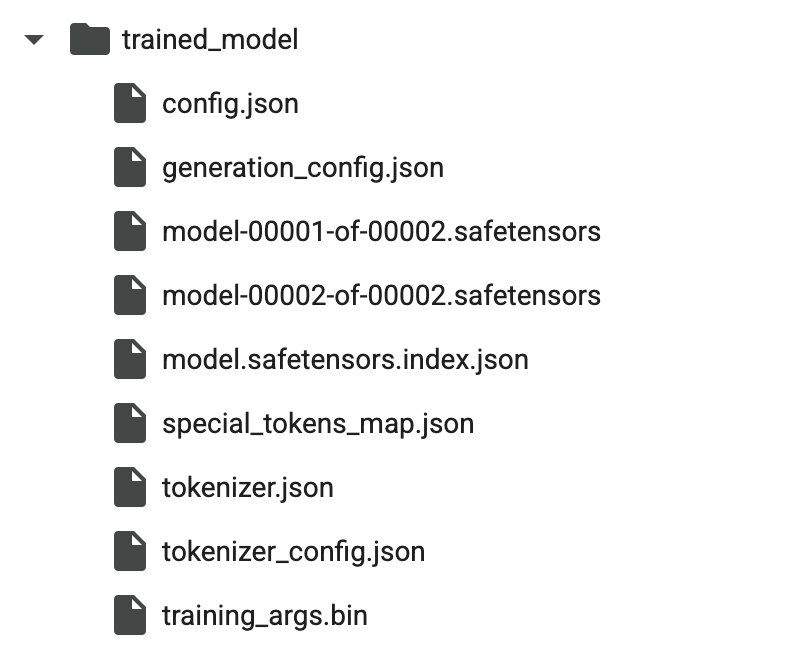

In [31]:
# 构造输入
prompt = "Human: 三原色是什么？\n\nAssistant:"
inputs = tokenizer(prompt, return_tensors="pt")

# 可选：使用 GPU
model = model.to("cuda")
inputs = {k: v.to("cuda") for k, v in inputs.items()}

# 推理生成
output = model.generate(
    **inputs,
    max_new_tokens=100,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    pad_token_id=tokenizer.eos_token_id
)

# 解码输出
tokenizer.decode(output[0], skip_special_tokens=True)

'Human: 三原色是什么？\n\nAssistant: 三原色（trinit color）是一组由三个基本色组成，即红、绿、蓝。它代表的是自然世界中颜色最基本的三个基色，即红、绿、蓝。三原色是一种自然颜色，它不会改变颜色，不会产生任何光波。它是一种中性颜色，它的颜色会随着光源的强度而变化。它是一种稳定的颜色，不会随着光源的变化而改变。它是一种容易辨认的颜色，不会产生混淆。'